In [45]:
import pandas as pd
import matplotlib
from matplotlib import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

# Dataset: https://www.kaggle.com/datasets/datasnaek/chess

In [46]:
df = pd.read_csv('games.csv')
print(df.columns)
print(df.shape)
print(df['winner'].unique())

Index(['id', 'rated', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'winner', 'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply'],
      dtype='object')
(20058, 16)
['white' 'black' 'draw']


In [47]:
def split_plus_first(s):
    return s.split('+')[0]
def split_plus_second(s):
    return s.split('+')[1]
def get_first_char(s):
    return s[0]
df['eco_letter'] = list(map(get_first_char,df['opening_eco']))
arr_mins = list(map(split_plus_first, df['increment_code']))
df['time_mins'] = list(map(int,arr_mins))
arr_inc = list(map(split_plus_second, df['increment_code']))
df['time_inc'] = list(map(int,arr_inc))
df['rating_diff'] = df['white_rating'] - df['black_rating']
df = df.drop(columns = ['id', 'victory_status', 'moves', 'created_at', 'last_move_at', 'increment_code','opening_name'])
df.head()

,rated,turns,winner,white_id,white_rating,black_id,black_rating,opening_eco,opening_ply,eco_letter,time_mins,time_inc,rating_diff
0,False,13,white,bourgris,1500,a-00,1191,D10,5,D,15,2,309
1,True,16,black,a-00,1322,skinnerua,1261,B00,4,B,5,10,61
2,True,61,white,ischia,1496,a-00,1500,C20,3,C,5,10,-4
3,True,61,white,daniamurashov,1439,adivanov2009,1454,D02,3,D,20,0,-15
4,True,95,white,nik221107,1523,adivanov2009,1469,C41,5,C,30,3,54


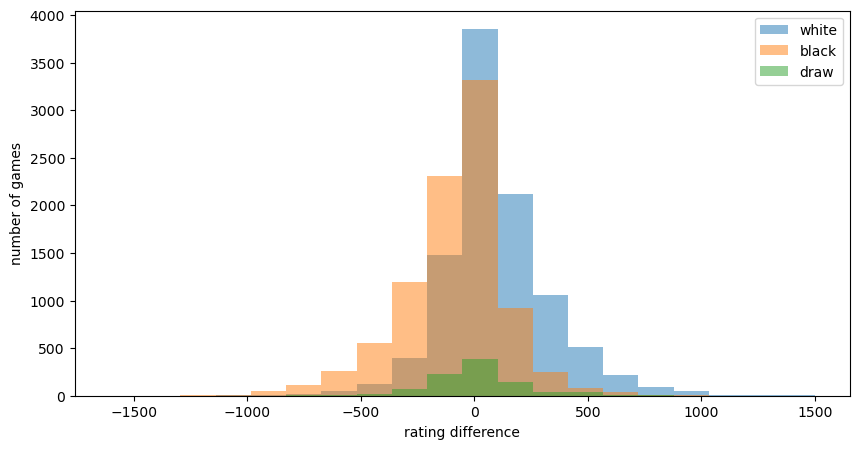

<Figure size 640x480 with 0 Axes>

In [49]:
categories = df['winner'].unique()
bin_range = (df['rating_diff'].min(),df['rating_diff'].max())

plt.figure(figsize=(10,5))

for c in categories:
    plt.hist(df[df['winner']==c]['rating_diff'],alpha=0.5,label=c,range=bin_range,bins=20)
plt.legend()
plt.ylabel('number of games')
plt.xlabel('rating difference')
plt.show()

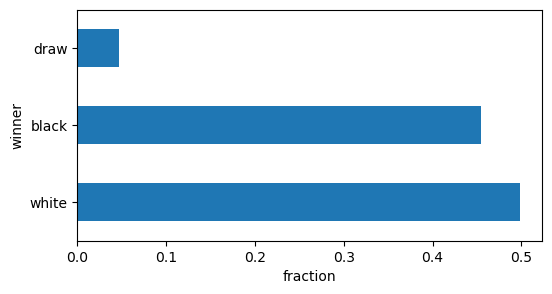

In [61]:
plt.figure(figsize=(6,3))
df['winner'].value_counts(normalize=True).plot.barh()
plt.xlabel('fraction')
plt.savefig('tgt_var.png')
plt.show()

In [33]:
dataset = [df[df['eco_letter']=='A']['white_rating'].values,
           df[df['eco_letter']=='B']['white_rating'].values,
           df[df['eco_letter']=='C']['white_rating'].values,
           df[df['eco_letter']=='D']['white_rating'].values,
           df[df['eco_letter']=='E']['white_rating'].values,]

plt.figure(figsize=(5,3))

plt.violinplot(dataset = dataset)
plt.xticks([1,2,3,4,5],['A','B', 'C', 'D', 'E'])
plt.ylabel('white rating')
plt.show()

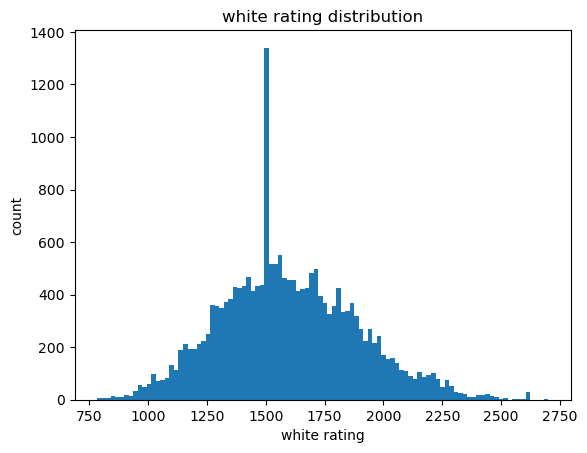

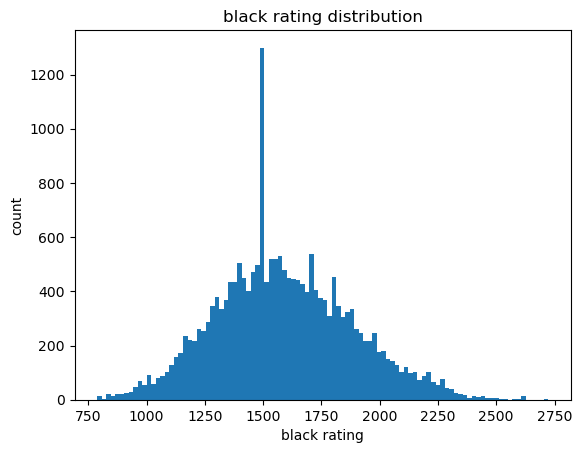

In [59]:
df['white_rating'].plot.hist(bins = 100)
plt.xlabel('white rating')
plt.ylabel('count')
plt.title('white rating distribution')
plt.savefig('white_rating_dist.png')
plt.show()

df['black_rating'].plot.hist(bins = 100)
plt.xlabel('black rating')
plt.ylabel('count')
plt.title('black rating distribution')
plt.savefig('black_rating_dist.png')
plt.show()

In [4]:
#adding prev_res_w, prev_res_b, win_frac_w, win_frac_b, loss_frac_w, loss_frac_b
df['prev_res_w'] = df.groupby('white_id')['winner'].shift(1).fillna('na')
df['prev_res_b'] = df.groupby('black_id')['winner'].shift(1).fillna('na')

g = df.groupby('white_id', sort=False)
prev_wins = g['winner'].transform(lambda s: s.eq('white').cumsum().shift(1).fillna(0).astype(int))
prev_loss = g['winner'].transform(lambda s: s.eq('black').cumsum().shift(1).fillna(0).astype(int))
prev_counts = g.cumcount()
win_frac_w = prev_wins/prev_counts.replace(0, np.nan)
loss_frac_w = prev_loss/prev_counts.replace(0, np.nan)
df['win_frac_w'] = win_frac_w
df['loss_frac_w'] = loss_frac_w

g = df.groupby('black_id', sort=False)
prev_wins = g['winner'].transform(lambda s: s.eq('black').cumsum().shift(1).fillna(0).astype(int))
prev_loss = g['winner'].transform(lambda s: s.eq('white').cumsum().shift(1).fillna(0).astype(int))
prev_counts = g.cumcount()
win_frac_b = prev_wins/prev_counts.replace(0, np.nan)
loss_frac_b = prev_loss/prev_counts.replace(0, np.nan)
df['win_frac_b'] = win_frac_b
df['loss_frac_b'] = loss_frac_b

In [5]:
#now it's time to drop the id columns so the algorithm makes predictions on the player's results but not their names
df = df.drop(columns = ['white_id', 'black_id'])

In [5]:
#info for feature matrix
#for col in df.columns:
#    print('column name: ', col, '\n', df[col].describe())

In [6]:
# prepare the feature matrix X
X = df.drop(columns = ['winner'])
# prepare the target variable y
y = df['winner']

In [7]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_ftrs = ['turns','white_rating', 'black_rating', 'time_mins', 'time_inc', 'rating_diff', 
            'win_frac_w', 'loss_frac_w', 'win_frac_b', 'loss_frac_b']
cat_ftrs = ['opening_eco', 'opening_ply', 'eco_letter']
ordinal_ftrs = ['rated', 'prev_res_w', 'prev_res_b']
ordinal_cats = [[False, True],['na', 'black', 'draw', 'white'],['na', 'white', 'draw', 'black']]

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='na')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [27]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier
def MLpipe_SKFold_Acc(X, y, preprocessor, ML_algo, param_grid):
    '''
    MLpipe_SKFold_Acc : Returns tests scores (using accuracy as metric) and models for a given set of parameters in the given ML algorithm
        Uses GridSearchCV on given hyperparameters to tune the models. Uses stratified kfold for splitting
    Parameters
    ----------
    X : Pandas DataFrame
        Feature matrix dataframe for ML algorithms. Does not need to be preprocessed
    y : Pandas Series
        Target variable for the ML algorithms to be run
    preprocessor : ColumnTransformer
        Preprocessor for the feature matrix X. Must preprocess all categories that need it and contain all necessary inputs
        such as series of categorical feature, ordering for ordinal features, etc...
    ML_algo : SciKitLearn Machine Learning Algorithm
        Algorithm to use in the models
        RandomForestClassifier, LogisticRegression, ElasticNet etc...
    param_grid : Dictionary
        Dictionary of hyperparameters to tune in the model. Must only include appropriate hyperparameters associated with ML_algo

    Returns
    -------
    test_scores : array
        array of test scores from the different tuned models
    best_models : array
        array of models that produced the test scores
    '''
    # lists to be returned 
    test_scores = []
    best_models = []
    final_models = []
    rand_states = np.linspace(2,92,10,dtype=int)
    for r in rand_states:
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=r)
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=r)
        pipe = make_pipeline(preprocessor,ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        final_models.append(grid)
        best_models.append(grid.best_params_)
        y_test_pred = final_models[-1].predict(X_test)
        test_scores.append(accuracy_score(y_test,y_test_pred))
    return test_scores, best_models

In [9]:
ML_algo = RandomForestClassifier()
param_grid = {
            'randomforestclassifier__n_estimators': [5],
            'randomforestclassifier__max_depth': [4,5,6],
            'randomforestclassifier__random_state': [42]
}
rf_test, rf_models = MLpipe_SKFold_Acc(X, y, preprocessor, ML_algo, param_grid)
print('rf mean, std', np.mean(rf_test), np.std(rf_test))

rf mean, std 0.5995513459621137 0.021511262836412855


In [36]:
ML_algo = KNeighborsClassifier()
param_grid = {
            'kneighborsclassifier__n_neighbors': [5,7,10],
            'kneighborsclassifier__weights': ['uniform','distance'],
}
# standard scaler
numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer()),
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])
knn_test, knn_models = MLpipe_SKFold_Acc(X, y, preprocessor, ML_algo, param_grid)
print('knn mean, std', np.mean(knn_test), np.std(knn_test))

knn mean, std 0.605034895314058 0.00867397806580257


In [34]:
ML_algo = GradientBoostingClassifier()
# standard scaler
param_grid = {
            'gradientboostingclassifier__learning_rate': [0.03],
            'gradientboostingclassifier__n_estimators': [100],          
            'gradientboostingclassifier__subsample': [0.66]
}

XGB_test, XGB_models = MLpipe_SKFold_Acc(X, y, preprocessor, ML_algo, param_grid)
print('XGB-sklearn mean, std', np.mean(XGB_test), np.std(XGB_test))

XGB-sklearn mean, std 0.6445663010967099 0.006154057572088128


In [11]:
# fit_transform the training set
#need to change y into 0s 1s and 2s
mapping = {
    'black': 0,
    'draw': 1,
    'white': 2
}
df['winner'] = df['winner'].map(mapping)
y = df['winner']
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

train size: (12034, 17)
validation size: (4012, 17)
test size: (4012, 17)
preprocessed train size: (12034, 377)
preprocessed validation size: (4012, 377)
preprocessed test size: (4012, 377)


In [42]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import f1_score

# parameters to try 
test_scores = []
test_f1s = []
for i in range(10):
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  "missing": [np.nan], 
                  "colsample_bytree": [0.9],
                  "random_state": [10*i+2],
                  "subsample": [0.66]}

    # create xgboost model and set parameters 
    XGB = xgboost.XGBClassifier(early_stopping_rounds=50)
    XGB.set_params(**ParameterGrid(param_grid)[0])

    # fit model to train data 
    XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

    # predict on validation 
    y_CV_pred = XGB.predict(df_CV)
    #print('the CV accuracy:',accuracy_score(y_CV,y_CV_pred))

    # predict on test 
    y_test_pred = XGB.predict(df_test)
    test_scores.append(accuracy_score(y_test,y_test_pred))
    test_f1s.append(f1_score(y_test,y_test_pred, average='weighted'))
print(np.mean(test_scores), np.mean(test_f1s))

0.8247756729810568 0.8116339715421914


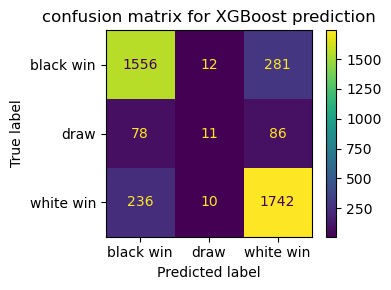

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_test,y_test_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['black win', 'draw', 'white win'])
fig, ax = plt.subplots(figsize=(4,3))
plt.title('confusion matrix for XGBoost prediction')
disp.plot(ax=ax)
plt.tight_layout()
plt.savefig('cm.png')
plt.show()

In [15]:
def MLpipe_SKFold_f1w(X, y, preprocessor, ML_algo, param_grid):
    '''
    Look above at MLpipeSKFold_f1w; this function does the same but returns weighted f1 scores rather than accuracy scores
    '''
    # lists to be returned 
    test_scores = []
    best_models = []
    final_models = []
    rand_states = np.linspace(2,92,10,dtype=int)
    for r in rand_states:
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=r)
        kf = StratifiedKFold(n_splits=4,shuffle=True,random_state=r)
        pipe = make_pipeline(preprocessor,ML_algo)
        grid = GridSearchCV(pipe, param_grid=param_grid,scoring = 'accuracy',
                        cv=kf, return_train_score = True)
        grid.fit(X_other, y_other)
        results = pd.DataFrame(grid.cv_results_)
        final_models.append(grid)
        best_models.append(grid.best_params_)
        y_test_pred = final_models[-1].predict(X_test)
        test_scores.append(f1_score(y_test,y_test_pred, average='weighted'))
    return test_scores, best_models

In [17]:
ML_algo = RandomForestClassifier()
param_grid = {
            'randomforestclassifier__n_estimators': [5],
            'randomforestclassifier__max_depth': [4,5,6],
            'randomforestclassifier__random_state': [42]
}
rf_test_f1, rf_models_f1 = MLpipe_SKFold_f1w(X, y, preprocessor, ML_algo, param_grid)
print('rf mean, std', np.mean(rf_test_f1), np.std(rf_test_f1))

rf mean, std 0.5757274293689613 0.02764504544033821


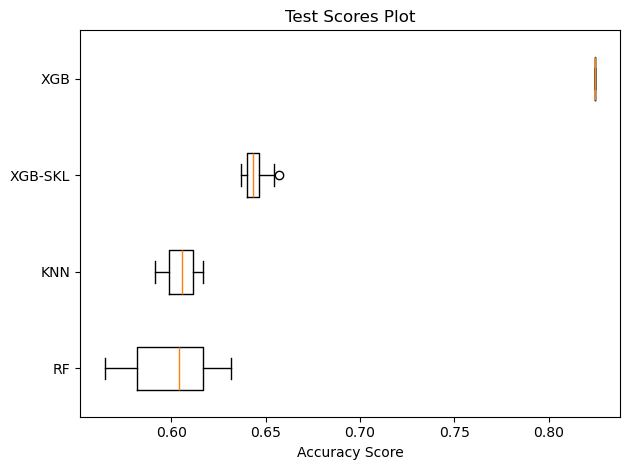

In [56]:
plt.boxplot([rf_test, knn_test, XGB_test, test_scores],tick_labels=['RF','KNN','XGB-SKL', 'XGB'],vert=False)
plt.title("Test Scores Plot")
plt.xlabel('Accuracy Score')
plt.tight_layout()
plt.savefig("TestScoresPlot.png", format='png')
plt.show()

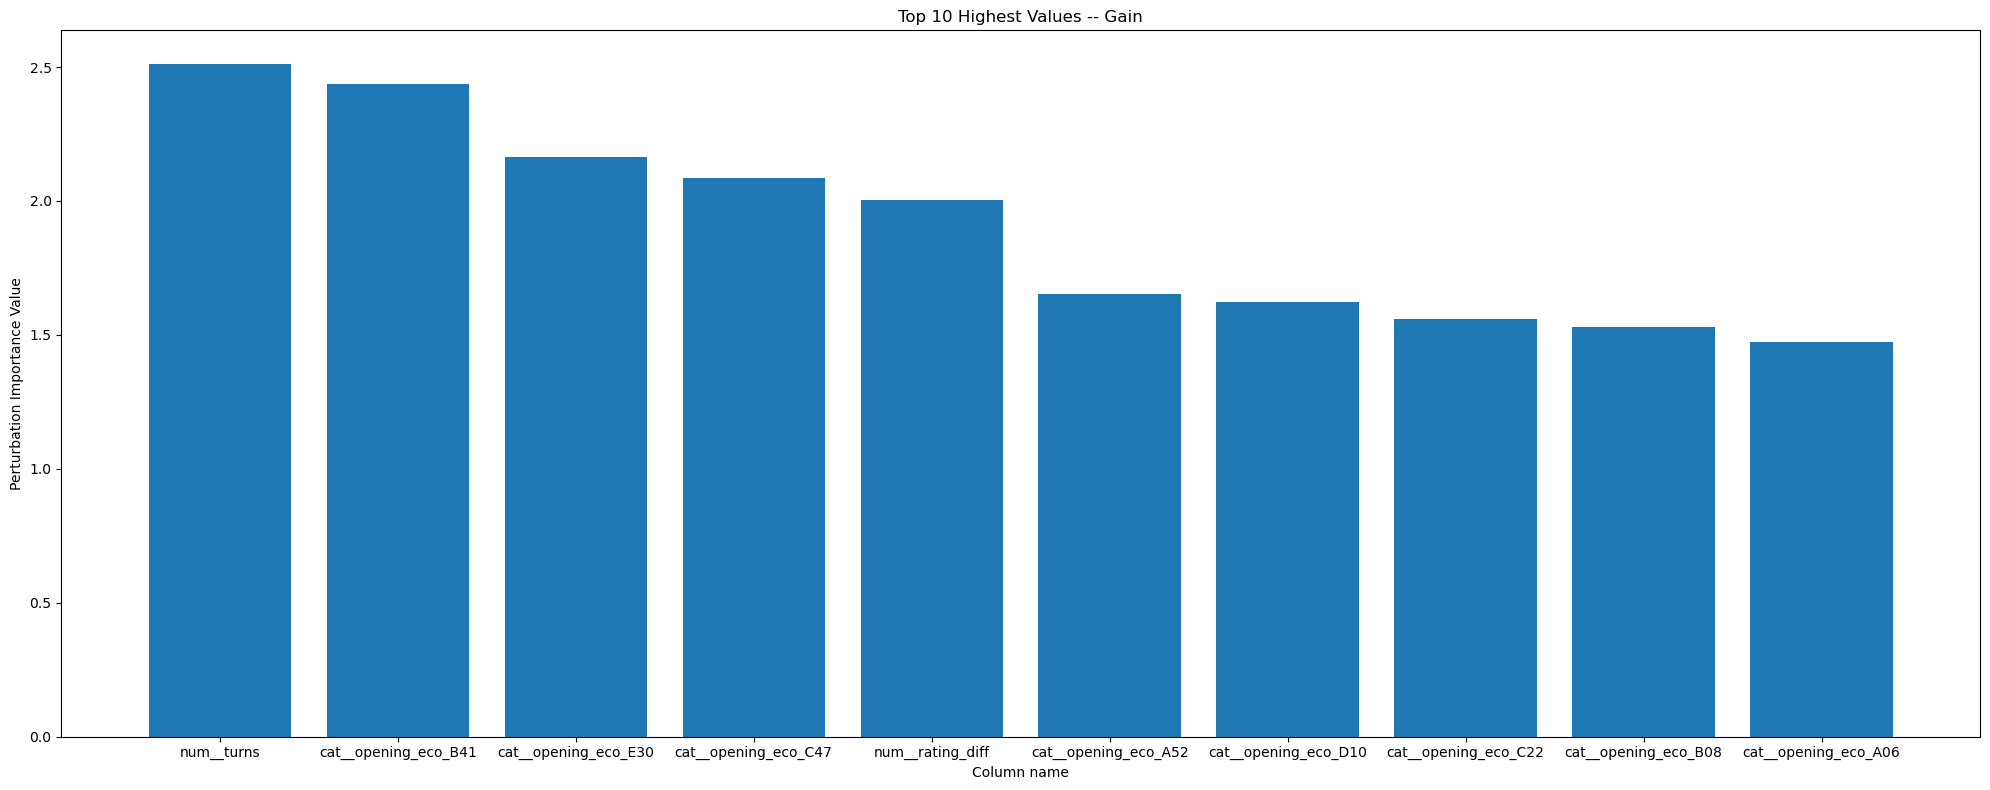

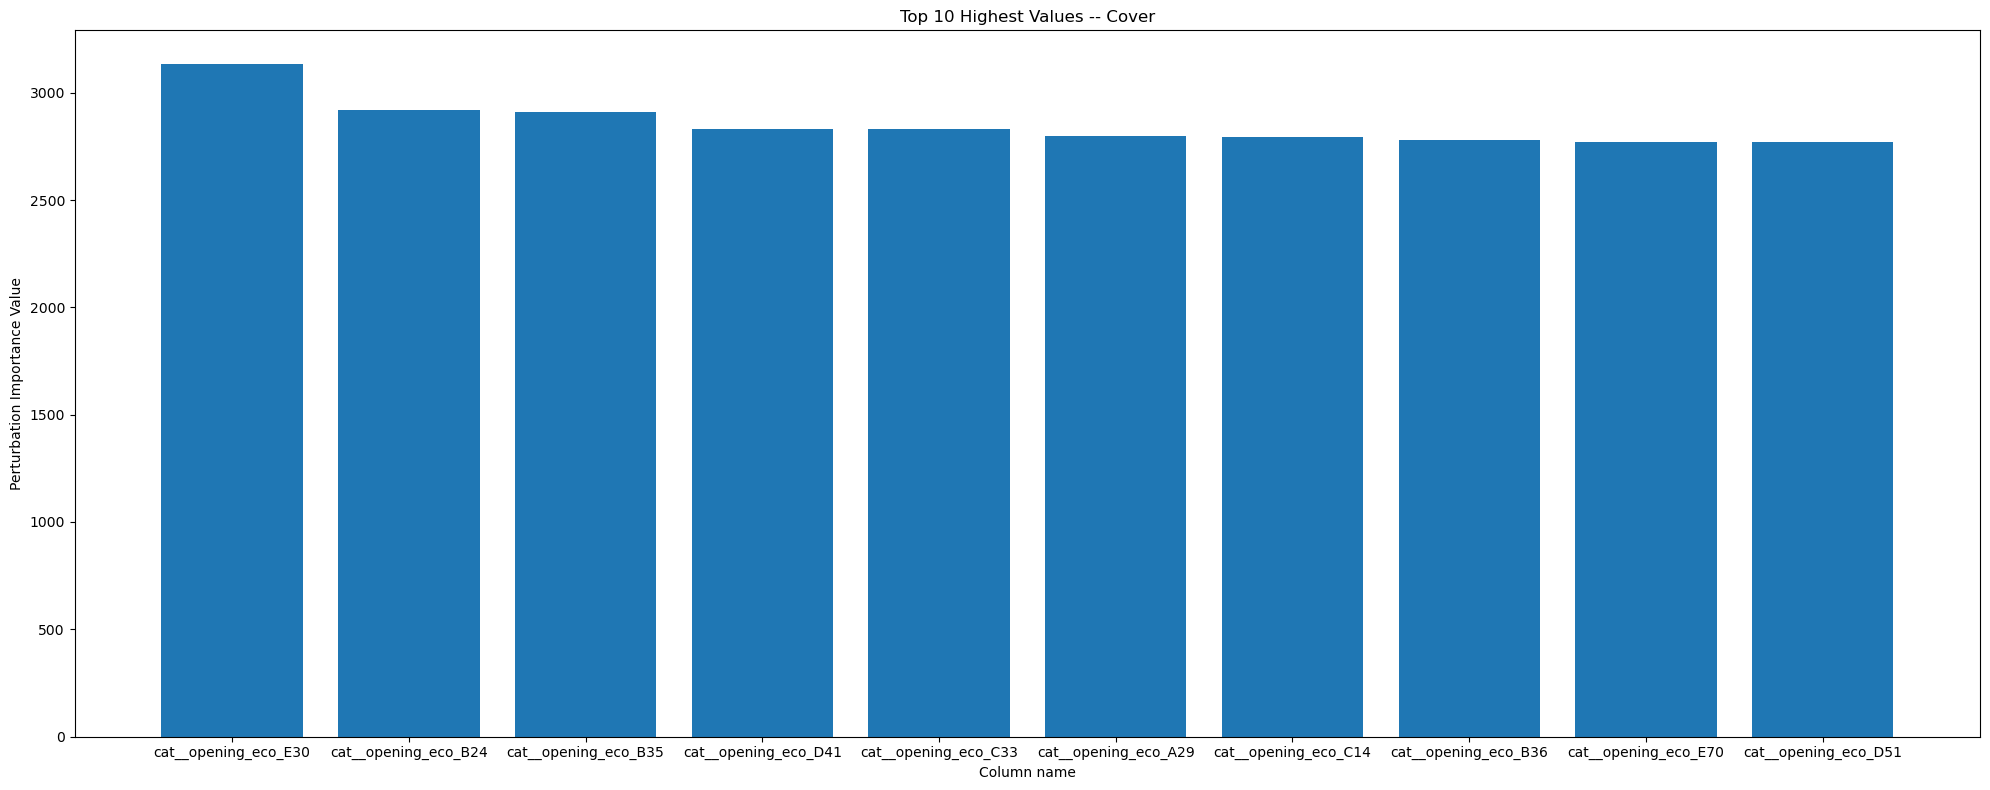

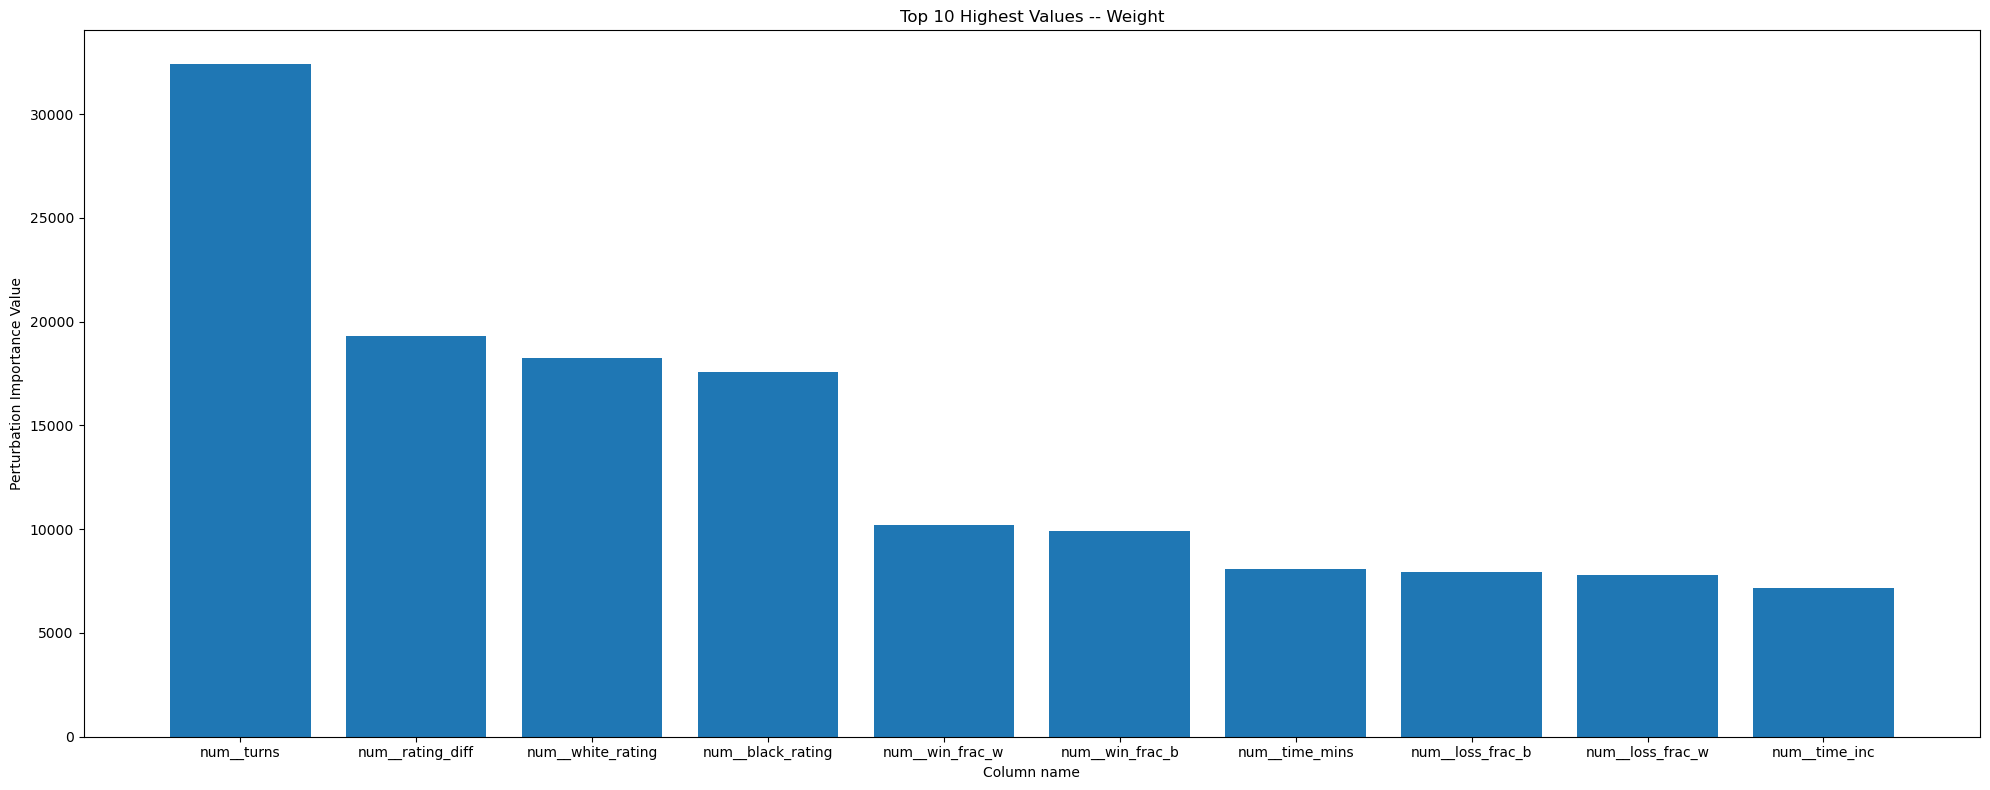

In [58]:
gain = XGB.get_booster().get_score(importance_type='gain')
cover = XGB.get_booster().get_score(importance_type='cover')
weight = XGB.get_booster().get_score(importance_type='weight')
#gain
topindcs = dict(sorted(gain.items(), key=lambda x: x[1], reverse=True)[:10])
col_names = list(topindcs.keys())
FPI_values = list(topindcs.values())
plt.figure(figsize=(20, 8))
plt.bar(col_names, FPI_values)
plt.xlabel("Column name")
plt.ylabel("Perturbation Importance Value")
plt.title("Top 10 Highest Values -- Gain")
plt.tight_layout()
plt.savefig("PFI_Gain.png")
plt.show()
#cover
topindcs = dict(sorted(cover.items(), key=lambda x: x[1], reverse=True)[:10])
col_names = list(topindcs.keys())
FPI_values = list(topindcs.values())
plt.figure(figsize=(20, 8))
plt.bar(col_names, FPI_values)
plt.xlabel("Column name")
plt.ylabel("Perturbation Importance Value")
plt.title("Top 10 Highest Values -- Cover")
plt.tight_layout()
plt.savefig("PFI_Cover.png")
plt.show()
#weight
topindcs = dict(sorted(weight.items(), key=lambda x: x[1], reverse=True)[:10])
col_names = list(topindcs.keys())
FPI_values = list(topindcs.values())
plt.figure(figsize=(20, 8))
plt.bar(col_names, FPI_values)
plt.xlabel("Column name")
plt.ylabel("Perturbation Importance Value")
plt.title("Top 10 Highest Values -- Weight")
plt.tight_layout()
plt.savefig("PFI_Weight.png")
plt.show()